In [1]:
import os
import functools
import operator
import gzip
import struct
import array
import numpy as np
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import os
from random import sample
from datetime import datetime

def show_sample_grid(data_x, data_y, layout_size_x, layout_size_y):
    f, axarr = plt.subplots(layout_size_x, layout_size_y, sharex=True, sharey=True, constrained_layout=True)
    for i in range(layout_size_x):
        for j in range(layout_size_y):
            index = np.random.randint(len(data_x))
            
            image = data_x[index]
            label = data_y[index]
            
            axarr[i,j].imshow(image.reshape(28,28), cmap='gray_r')
#             axarr[i,j].set_xlabel(label)
            axarr[i,j].axis('off')
            axarr[i,j].set_title(label)

    
def fopen(filepath, options = 'rb'):

    DATA_TYPES = {
        0x08: 'B',  # unsigned byte
        0x09: 'b',  # signed byte
        0x0b: 'h',  # short (2 bytes)
        0x0c: 'i',  # int (4 bytes)
        0x0d: 'f',  # float (4 bytes)
        0x0e: 'd'   # double (8 bytes)
    }  

    __fopen = open

    if os.path.splitext(filepath)[1] == '.gz':
        __fopen = gzip.open

    with __fopen(filepath, options) as fd:
        header = fd.read(4)
        zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

        data_type = DATA_TYPES[data_type]

        dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                        fd.read(4 * num_dimensions))
        data = array.array(data_type, fd.read())
        data.byteswap()
        expected_items = functools.reduce(operator.mul, dimension_sizes)

        return np.array(data).reshape(dimension_sizes)

def load_data_set(images_file_path, labels_file_path):
    return fopen(images_file_path), fopen(labels_file_path)

# Подготовка данных

In [2]:
train_x, train_y = load_data_set('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test_x,  test_y  = load_data_set('t10k-images-idx3-ubyte.gz',  't10k-labels-idx1-ubyte.gz')

print('Размер тренировочных данных: x={}, y={}'.format(train_x.shape, train_y.shape))
print('Размер тестовых данных:  x={}, y={}'.format(test_x.shape, test_y.shape))

Размер тренировочных данных: x=(60000, 28, 28), y=(60000,)
Размер тестовых данных:  x=(10000, 28, 28), y=(10000,)


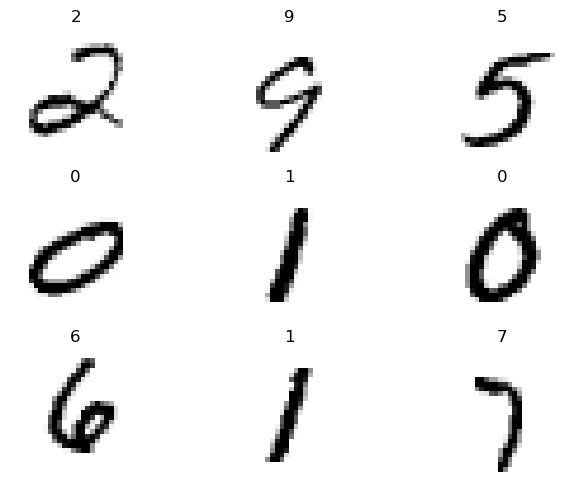

In [3]:
show_sample_grid(train_x, train_y, 3, 3)

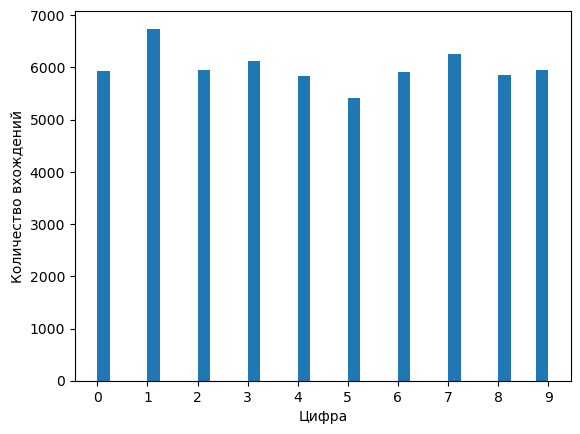

In [4]:
bins = list(set(train_y))
fig, ax = plt.subplots()

ax.hist(train_y, 'auto', align='mid')
ax.set_xticks(bins)

plt.xlabel("Цифра")
plt.ylabel("Количество вхождений")

plt.show()

Как можно видеть на данной гистограмме отображено количество всевозможных рукописных цифр, представленных в датасете. Для нас важно увидеть, что распределение в среднем равномерно. Представлены цифры от 0 до 9.

### Преобразование данных

Перед тем как выполнить преобразование данных, определим некоторые величины. Зафиксируем количество представленных в датасете цифр, максимальмальную и минимальную яркость пикселей:

In [5]:
labels_size = len(set(train_y)); print('Количество классов в датасете:', labels_size)

Количество классов в датасете: 10


In [6]:
min_color_value = train_x.min(); print('Минимальная яркость:', min_color_value)
max_color_value = train_x.max(); print('Максимальная яркость:', max_color_value)

Минимальная яркость: 0
Максимальная яркость: 255


Выполним преобразование двумерных матриц яркостей пикселей в вектор. Нормализуем данные. Выполним бинаризацию признаков labels:

In [7]:
length, width, height = train_x.shape
train_x = (train_x.reshape(length, width * height) - min_color_value) / max_color_value.astype('float32')
train_y = np.eye(labels_size)[train_y]

print('Размер тренировочных данных: x={}, y={}'.format(train_x.shape, train_y.shape))

Размер тренировочных данных: x=(60000, 784), y=(60000, 10)


In [8]:
length, width, height = test_x.shape
test_x = (test_x.reshape(length, width * height) - min_color_value) / max_color_value.astype('float32')
test_y = np.eye(labels_size)[test_y]
    
print('Размер тестовых данных: x={}, y={}'.format(test_x.shape, test_y.shape))

Размер тестовых данных: x=(10000, 784), y=(10000, 10)


# Метод обратного распространения ошибки

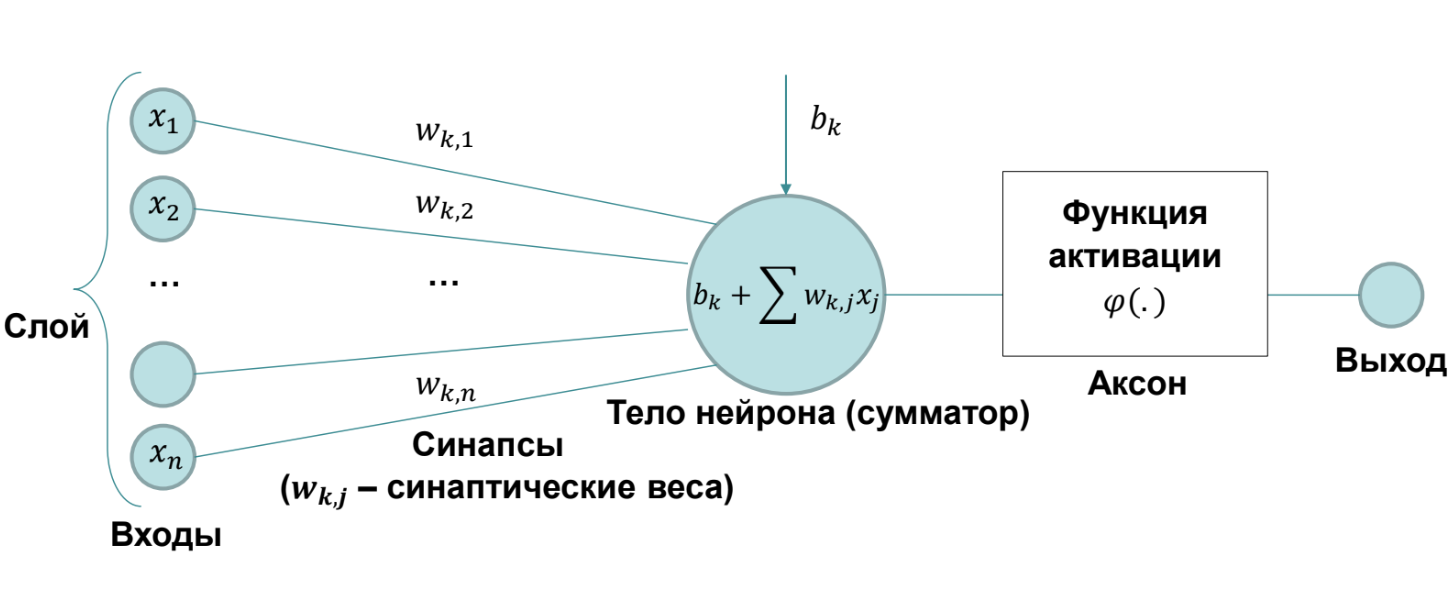


Метод обратного распространения ошибки определяет стратегию изменения параметров сети $w$ в ходе обучения с использованием градиентных методов оптимизации. Градиентные методы на каждом шаге уточняют значения параметров:

$$ w_{k+1} = w_{k} - \lambda p(w) $$

где $w_k$ - это синаптические веса на $k$-ой итерации, а $\lambda$ - скорость обучения, причем $ \lambda \in (0;1) $

$p(w)$ - соответствует направлению в многомерном пространстве параметров

Классический метод обратного распространения ошибки определяет величину $p(w)$, как антиградиент функции ошибки на $k$-итерации метода:

$$ p(w) = -\nabla E(w_{k})  $$

Функция ошибки для **стохастического градиентного спуска** определяется так:

$$ E(w) = \frac{1}{L}\sum_{k=1}^{L} \left\{ \frac{1}{2}\sum_{j=1}^{M}(y_j^k - u_j^k  )^2   \right\} $$ 

$u_j^k$ выходной сигнал $j$-ого нейрона на слое $k$:

$$u_j = \phi^{(2)}(\sum_{s=0}^{K}{ w_{js}^{(2)} v_s }) = \phi^{(2)}(\sum_{s=0}^{K}{ w_{js}^{(2)} \phi^{(1)}(\sum_{i=0}^{N}{w_{si}^{(1)}{x_i}}) })$$


<!-- $$ E(w) = \frac{1}{2}\sum_{j=1}^{M}{( y_j - \phi^{(2)} (\sum_{s=0}^{K}w_{js}^{(2)} \phi^{(1)} (\sum_{i=0}^{N}w^{(1)}_{si}x_i) )  )^2} $$ -->

Следовательно, приведем формулы для вычисления градиента:

$$ E(w) = \frac{1}{2}\sum_{j=1}^{M}(y_j^k - u_j^k  )^2 $$ 

$$ E(w) = \frac{1}{2}\sum_{j=1}^{M}(y_j^k - \phi^{(2)}(\sum_{s=0}^{K}{ w_{js}^{(2)} \phi^{(1)}(\sum_{i=0}^{N}{w_{si}^{(1)}{x_i}}) })  )^2  $$ 

 $$\frac{\partial E}{\partial w_{js}^{(2)}} = -(y_j - u_j) \frac{d \phi^{(2)}(g_j)}{d g_j}v_s $$

$$\frac{\partial E}{\partial w_{js}^{(1)}} = -\sum_{j=1}^{M}(y_j - u_j) \frac{d \phi^{(2)}(g_j)}{d g_j}w_{js}^{(2)} \frac{d \phi^{(1)}(f_s)}{d f_s} x_i $$

$$f_s = \sum_{i=0}^{N}w_{si}^{(1)}x_i  \space\space\space\space\space\space\space    g_j = \sum_{s=0}^{K}{w_{js}^{(2)}v_s}$$

В формулах фигурируют функция активации $\phi(x)$ и ее производная. В нашем случае функция определяется как ReLU, соответственно определим функцию ReLU и её производную:

In [9]:
def relu(x):
#     xx = x.copy()
    
#     for i in range(len(xx)):
#         for j in range(len(xx[i])):
#             xx[i][j] = max(0, xx[i][j])
            
#     return xx

    return np.maximum(x, 0)

def derivative_relu(x):
#     xx = x.copy()
    
#     for i in range(len(xx)):
#         for j in range(len(xx[i])):            
#             xx[i][j] = float(xx[i][j] > 0)

#     return xx

    return np.where(x > 0.0, 1, 0)

В качестве функции активации на **последнем слое** рекомендуется выбирать функцию **softmax**:

$$ \phi(u_j) = \frac{e^{u_j}}{\sum_{i=1}^{M}{e^{u_i}}}  $$

In [10]:
def softmax(u):
    shift = np.max(u, axis=u.ndim - 1, keepdims=True)
    u = np.exp(u - shift)
    denominator = np.sum(u, axis=u.ndim - 1, keepdims=True)

    return u / denominator

В качестве функции ошибки для **задачи классификации**, где каждый входной объект относится **только к одному классу**, выбирается **кросс-энтропия**:

$$ E(w) = - \frac{1}{L} \sum_{k=1}^{L}\sum_{m=1}^{M} y_m^k \space ln(u_m^k) $$

где $y_j^k = 1$ <=> $x^k$ принадлежит классу $j$, иначе $y_j^k = 0$

Соответственно, определим функцию:

In [11]:
def cross_entropy(y, y_predicted):
    return np.mean(-np.sum(y * np.log(y_predicted), axis=1))

Точность классификации определяется следующей функцией:

In [12]:
def calc_accuracy(y, y_predicted):
    return np.mean(np.argmax(y, axis=1) == np.argmax(y_predicted, axis=1))

## Этапы обучения
### Инициализация синаптических весов сети
Случайным образом из некоторого распределения.

### Прямой  проход:
1. Вычисление значений выходных сигналов нейронов всех слоев $v_s$ и $u_j$
2. Вычисление значений производных функций активации на каждом слое сети $\frac{d \phi^{(2)}(g_j)}{d g_j}$ и $\frac{d \phi^{(1)}(f_s)}{d f_s}$

### Обратный  проход:
1. Вычисление значений целевой функций и её градиента $\frac{\partial E}{\partial w_{js}^{(2)}}$ и $\frac{\partial E}{\partial w_{js}^{(1)}}$
2. Корректировка синаптических весов:
$$w_{k+1} = w_{k} - \nabla E(w_{k}) $$

Таким образом, определим методы прямого и обратного прохода как **forward** и **backward** соответственно:

In [13]:
class Network():
    def __init__(self, input_neurons_size, hidden_neurons_size, out_neurons_size):
        self.input_neurons_size  = input_neurons_size
        self.hidden_neurons_size = hidden_neurons_size
        self.out_neurons_size    = out_neurons_size
        
        mean = 0.0
        stdw = pow(hidden_neurons_size, -0.5)
        stdb = pow(hidden_neurons_size, -0.5)
        
        # первый слой
        self.w0 = np.random.normal(0.0, stdw, size=(input_neurons_size, hidden_neurons_size))
        self.b0 = np.random.normal(0.0, stdb, size=(hidden_neurons_size))
        
        # второй слой
        self.w1 = np.random.normal(0.0, stdw, size=(hidden_neurons_size, out_neurons_size))
        self.b1 = np.random.normal(0.0, stdb, size=(out_neurons_size))

    # Прямой проход
    def forward(self, x):
        x = np.matmul(x, self.w0) + self.b0
        
        self.w0_1 = x.copy()
        
        x = relu(x)
        
        self.w1_1 = x.copy()

        x = np.matmul(x, self.w1) + self.b1
        x = softmax(x)
        
        return x
    
    # Обратный проход
    def backward(self, x, y, y_predicted, learning_rate):
        e1 = y_predicted - y
        e0 = np.matmul(e1, self.w1.T) * derivative_relu(self.w0_1)

        delta = 1.0 / len(x)

        self.w0 = self.w0 - learning_rate * delta * np.matmul(x.T, e0)
        self.b0 = self.b0 - learning_rate * delta * np.sum(e0, axis=0)
        
        delta = 0.925 / len(x)

        self.w1 = self.w1 - learning_rate * delta * np.matmul(self.w1_1.T, e1)
        self.b1 = self.b1 - learning_rate * delta * np.sum(e1, axis=0)
        
    def training_iteration(self, x, y, learning_rate):
        y_predicted = self.forward(x)
        
        self.backward(x, y, y_predicted, learning_rate)
        
    def validate(self, x, y):
        y_predicted = self.forward(x)
        
        loss = cross_entropy(y, y_predicted)
        accuracy = calc_accuracy(y, y_predicted)
        
        return loss, accuracy
        

In [14]:
def train(network, train_x, train_y, epochs=20, learning_rate=0.1, batch_size=8):
        print(' №  |    loss    |  accuracy  ')
        
        start = datetime.now()
        
        for epoch in range(epochs):
            for offset in range(0, len(train_x), batch_size):
                
                batch_x = train_x[offset:offset + batch_size]
                batch_y = train_y[offset:offset + batch_size]
                
                network.training_iteration(batch_x, batch_y, learning_rate)

            loss, accuracy = network.validate(train_x, train_y)
            
            print(' {:2d} | {:1.8f} | {:1.8f}'.format(epoch, loss, accuracy))
        
        end = datetime.now()
        time = (end - start).total_seconds()
        
        print('Время обучения {} сек'.format(time))

In [15]:
input_neurons_size = train_x.shape[1]
hidden_neurons_size = 300
learning_rate = 0.1
class_count = 10
batch_size = 32
epochs = 20

network = Network(input_neurons_size, hidden_neurons_size, out_neurons_size = class_count)
train(network, train_x, train_y, epochs, learning_rate, batch_size=batch_size)

loss, accuracy = network.validate(test_x, test_y)
print("Проверка на тестовом наборе данны: loss = {}, accuracy = {}".format(loss, accuracy))


# for batch in range(0, batch_size, 8):
#     network = Network(input_neurons_size, hidden_neurons_size, out_neurons_size = class_count)
#     train(network, train_x, train_y, epochs, learning_rate, batch_size=batch_size)
    
#     loss, accuracy = network.validate(test_x, test_y)
#     print("Проверка на тестовом наборе данны: loss = {}, accuracy = {}".format(loss, accuracy))

 №  |    loss    |  accuracy  
  0 | 0.18030340 | 0.94538333
  1 | 0.11749829 | 0.96486667
  2 | 0.08576894 | 0.97406667
  3 | 0.06666954 | 0.98045000
  4 | 0.05410252 | 0.98431667
  5 | 0.04543570 | 0.98696667
  6 | 0.03898824 | 0.98866667
  7 | 0.03366435 | 0.99055000
  8 | 0.02937791 | 0.99158333
  9 | 0.02581692 | 0.99288333
 10 | 0.02294789 | 0.99368333
 11 | 0.02030838 | 0.99468333
 12 | 0.01831744 | 0.99538333
 13 | 0.01663469 | 0.99581667
 14 | 0.01489992 | 0.99655000
 15 | 0.01353233 | 0.99698333
 16 | 0.01262464 | 0.99713333
 17 | 0.01103817 | 0.99788333
 18 | 0.01031717 | 0.99811667
 19 | 0.00934721 | 0.99846667
Время обучения 85.648099 сек
Проверка на тестовом наборе данны: loss = 0.06740795128625024, accuracy = 0.9801


In [16]:
loss, accuracy = network.validate(test_x, test_y)
print("Проверка на тестовом наборе данны: loss = {}, accuracy = {}".format(loss, accuracy))

Проверка на тестовом наборе данны: loss = 0.06740795128625024, accuracy = 0.9801
